select subject session FOV

In [1]:
import BCI_analysis, os
BCI_analysis.io_suite2p.get_canned_file_version()

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


'1.02'

In [5]:
# import numpy as np
# data = np.load(os.path.join(save_path,'BCI_58-070323.npy'),allow_pickle = True).tolist()

In [2]:
import BCI_analysis, os
local_temp_dir = '/home/jupyter/temp/' 
metadata_dir = '/home/jupyter/bucket/Metadata/' 
raw_data_path ='/home/jupyter/bucket/Data/Calcium_imaging/raw/Bergamo-2P-Photostim/' 
suite2p_path = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/'
behavior_data_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/'
setup = 'Bergamo-2P-Photostim'#'DOM3-MMIMS'
save_path = "/home/jupyter/bucket/Data/Calcium_imaging/canned_sessions"
fov = None#'FOV_01'
subject = ['BCI_58','BCI_59','BCI_60','BCI_64','BCI_65']#
BCI_analysis.io_suite2p.generate_canned_sessions(suite2p_path,
                                                 raw_data_path,
                                                 behavior_data_path,
                                                 save_path,
                                                 overwrite=False,
                                                 mouse_list=subject,
                                                 fov_list=fov, 
                                                 session_list=None)




['FOV_01', 'FOV_02']


NameError: name 'BCI_analysis' is not defined

In [175]:
data_dict['BCI_1']

dict_keys(['F', 'Fraw', 'df_closedloop', 'centroidX', 'centroidY', 'Ftrace', 'trace_corr', 'dist', 'conditioned_neuron_coordinates', 'conditioned_neuron', 'reward_time', 'step_time', 'trial_start', 'lick_time', 'threshold_crossing_time'])

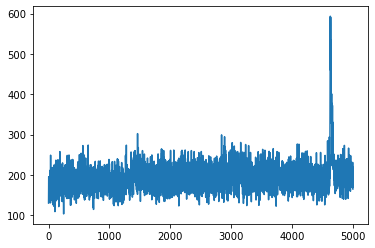

In [174]:
plt.plot(data_dict['BCI_1']['Ftrace'][0,:5000])

(array([404., 247.,  36.,   5.,   0.,   3.,   1.,   0.,   0.,   1.]),
 array([  24.360914,  316.21027 ,  608.05963 ,  899.909   , 1191.7583  ,
        1483.6077  , 1775.457   , 2067.3064  , 2359.1558  , 2651.0051  ,
        2942.8545  ], dtype=float32),
 <BarContainer object of 10 artists>)

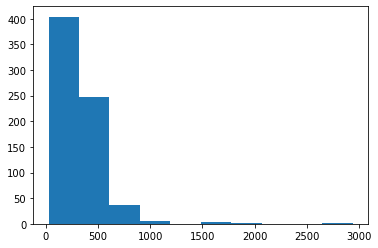

In [158]:
plt.hist(np.nanmax(data_dict['BCI_1']['Ftrace'],1))

In [2]:
import pandas as pd
metadata = {'filename':[],
           'mouse':[],
           'session':[],
           'fov':[],
           'neuron number':[],
           'spontaneous length (s)':[],
           'BCI_1 CN':[],
           'BCI_1 trial number':[],
           'BCI_1 hit rate':[],
           'BCI_2 CN':[],
           'BCI_2 trial number':[],
           'BCI_2 hit rate':[],
           'photostim group number':[],
           'photostim repeats per group':[]}
#generate metadata table
import numpy as np
files = os.listdir(save_path)
for file in files:
    if '.npy' not in file:
        continue
    data_dict = np.load(os.path.join(save_path,file),allow_pickle = True).tolist()
    if 'spont' in data_dict.keys():
        metadata['spontaneous length (s)'].append(int(data_dict['spont']['Ftrace'].shape[1] * data_dict['dt_si']))
    else:
        metadata['spontaneous length (s)'].append(0)
    metadata['filename'].append(file)
    metadata['mouse'].append(data_dict['mouse'])
    metadata['session'].append(data_dict['session'])
    metadata['fov'].append(data_dict['fov'])
    metadata['neuron number'].append(len(data_dict['iscell']))
    for k in ['BCI_1','BCI_2']:#,'BCI_3','BCI_4']:
        if k not in data_dict.keys():
            metadata['{} CN'.format(k)].append(None)
            metadata['{} trial number'.format(k)].append(None)
            metadata['{} hit rate'.format(k)].append(None)
        else:
            metadata['{} CN'.format(k)].append(data_dict[k]['conditioned_neuron'])
            metadata['{} trial number'.format(k)].append(data_dict[k]['F'].shape[2])
            metadata['{} hit rate'.format(k)].append(np.round(sum(data_dict[k]['reward_time'])/data_dict[k]['F'].shape[2],2))
    if 'photostim' in data_dict.keys():
        metadata['photostim group number'].append(data_dict['photostim']['favg'].shape[2])
        metadata['photostim repeats per group'].append(data_dict['photostim']['Fstim'].shape[2]/data_dict['photostim']['favg'].shape[2])
    else:
        metadata['photostim group number'].append(None)
        metadata['photostim repeats per group'].append(None)
df = pd.DataFrame(metadata)
df.to_csv(os.path.join(save_path,'metadata.csv'))

In [31]:
# test canned sessions
import pandas as pd
import numpy as np
df = pd.read_csv(os.path.join(save_path,'metadata.csv'))

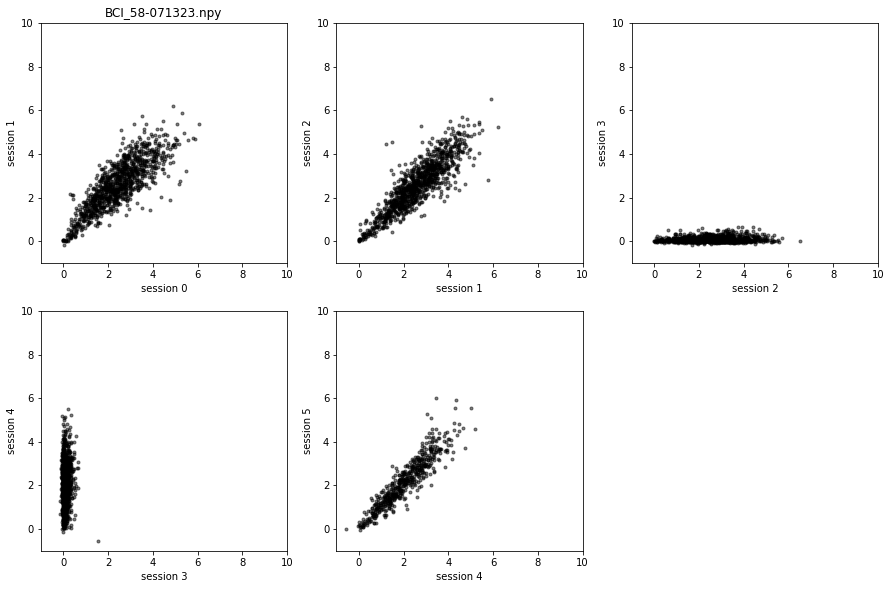

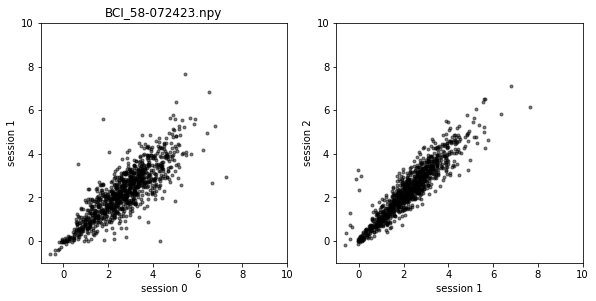

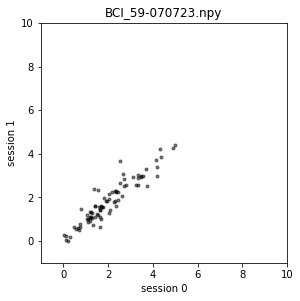

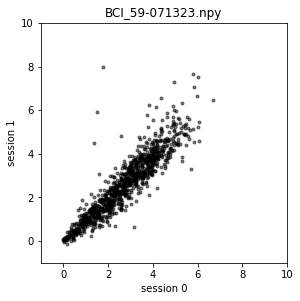

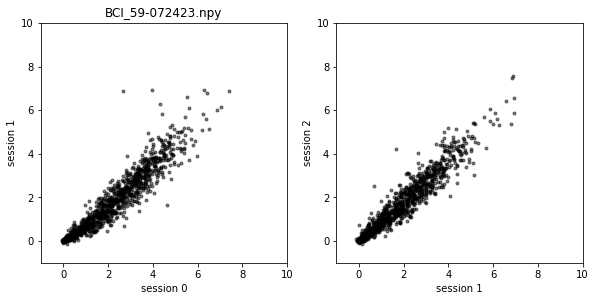

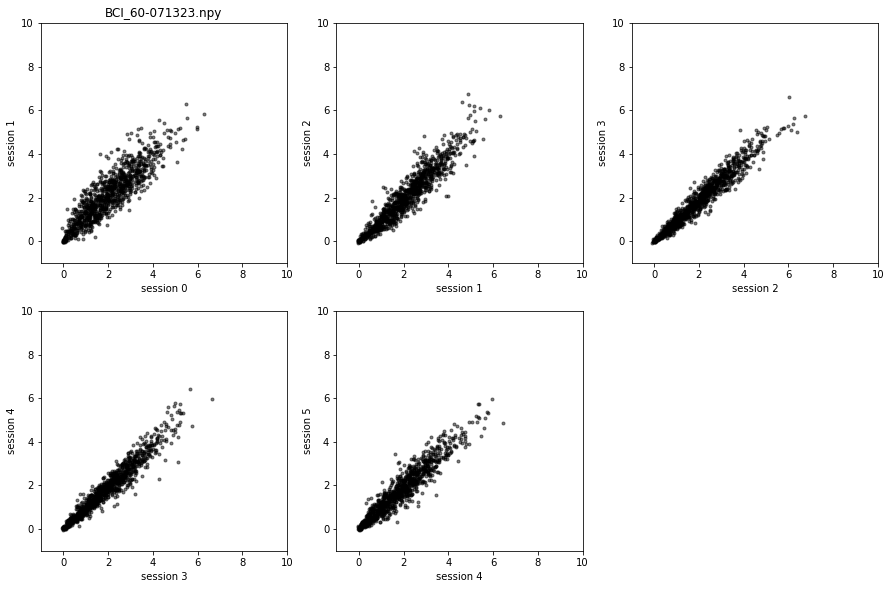

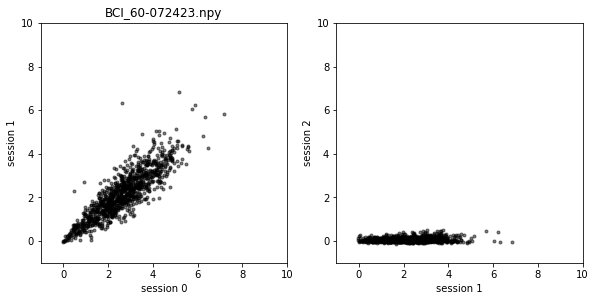

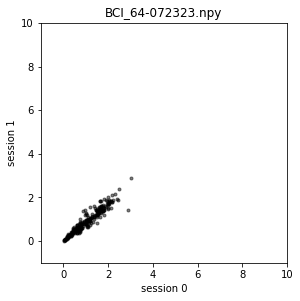

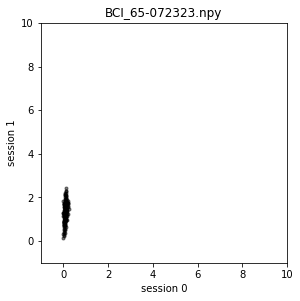

In [149]:
max_direct_photostim_dist = 10

for subject in df.mouse.unique():
    for fov in df.loc[df.mouse == subject].fov.unique():
        df_sessions = df.loc[(df.mouse == subject) & (df.fov == fov)]
        direct_photostim_amplitudes = []
        fov_direct_amplitudes = []
        for session, filename,df_now  in zip(df_sessions.session,df_sessions.filename,df_sessions.iterrows()):
            
            data_dict = np.load(os.path.join(save_path,filename),allow_pickle = True).tolist()
            if df_now[1]['photostim group number']>0:
                direct_amplitudes = []
                
                for pg in np.unique(data_dict['photostim']['seq']):
                    pidx = data_dict['photostim']['seq'] == pg
                    Fstim_now = np.nanmean(data_dict['photostim']['Fstim'][:,:,pidx],2)
                    indirect_cells = data_dict['photostim']['stimDist'][:,pg-1]>max_direct_dist
                    amplitudes = np.nanmean(Fstim_now[8:15,:],0)-np.nanmean(Fstim_now[:4,:],0)
                    amplitudes[indirect_cells] = np.nan
                    direct_amplitudes.append(amplitudes)
                
                fov_direct_amplitudes.append(direct_amplitudes)
        fig = plt.figure(figsize = [15,15])
        for i,(a1,a2) in enumerate(zip(fov_direct_amplitudes[:-1],fov_direct_amplitudes[1:])):
            
            ax = fig.add_subplot(3,3,i+1)
            if i == 0:
                ax.set_title(filename)
            ax.plot(np.concatenate(a1),np.concatenate(a2),'k.',alpha = .5)
            ax.set_xlabel('session {}'.format(i))
            ax.set_ylabel('session {}'.format(i+1))
            plt.xlim([-1,10])
            plt.ylim([-1,10])

            
        
        
            #pass


In [137]:
np.concatenate(a1)

array([nan, nan, nan, ..., nan, nan, nan])

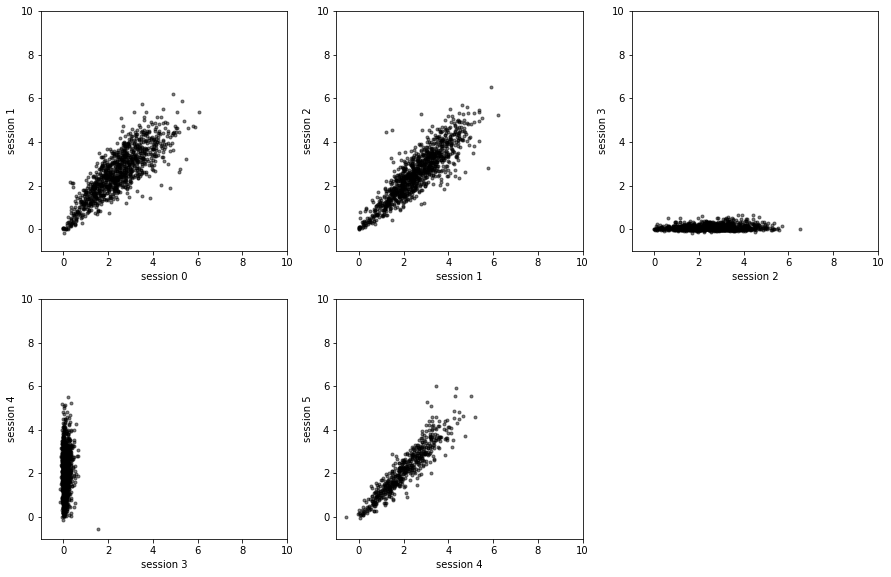

In [148]:

#len(fov_direct_amplitudes)

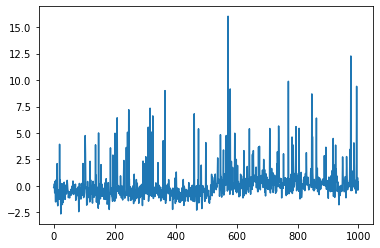

In [119]:
plt.plot(data_dict['spont']['Ftrace'][275,:1000])

In [100]:
np.argmin(amplitudes)

275

In [129]:


    
    #pass

''

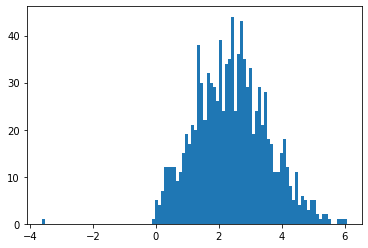

In [130]:
plt.hist(np.concatenate(direct_amplitudes),100)
''

array([ 76,  79, 145, 189, 244, 271, 368, 376, 402, 408, 489])

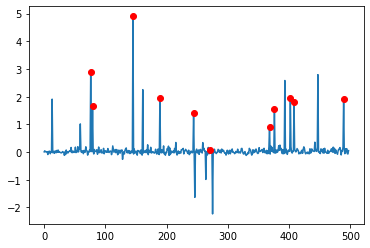

In [92]:
plt.plot(amplitudes)
plt.plot(np.where(direct_cells)[0],amplitudes[direct_cells],'ro')
#plt.ylim([-1,10])

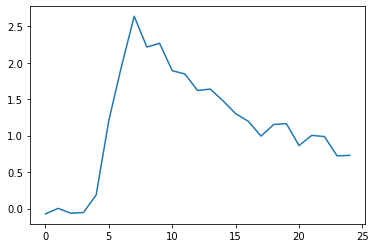

In [65]:
import matplotlib.pyplot as plt
Fstim_now.shape
plt.plot(Fstim_now[:,np.where(direct_cells)[0][3]])

In [36]:
data_dict['photostim'].keys()

dict_keys(['FstimRaw', 'Fstim', 'seq', 'favg', 'stimDist', 'stimPosition', 'centroidX', 'centroidY', 'slmDist', 'stimID', 'siHeader'])

In [ ]:
##### old canning
# import BCI_analysis, os
# local_temp_dir = '/home/jupyter/temp/' 
# metadata_dir = '/home/jupyter/bucket/Metadata/' 
# raw_scanimage_dir_base ='/home/jupyter/bucket/Data/Calcium_imaging/raw/' 
# suite2p_dir_base = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/'
# bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/'
# setup = 'Bergamo-2P-Photostim'#'DOM3-MMIMS'
# save_path = "/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba"
# fov = 'FOV_01'
# subject = 'BCI_66'
# BCI_analysis.io_suite2p.suite2p_to_npy(os.path.join(suite2p_dir_base,setup), 
#                                        os.path.join(raw_scanimage_dir_base,setup), 
#                                        os.path.join(bpod_path,setup),
#                                        save_path, 
#                                        overwrite=False, 
#                                        mice_name = subject,
#                                        fov_list = [fov],
#                                        session_list=None,#['072323'],
#                                        max_frames = 500)

FOV: FOV_01, Session Date: .ipynb_checkpoints
Session already exists at /home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba/BCI_66/BCI_66-092523-FOV_01.npy, and overwrite=False


In [4]:
# #register Z-stack
# import os
# from pathlib import Path
# subject = 'PKJ_04'
# session = '042123'
# z_stack = 'stack_00001.tif'
# os.chdir('/home/jupyter/Scripts/Suite2p_pipeline/utils/')
# import utils_imaging as utils_imaging
# local_temp_dir = '/home/jupyter/temp'
# temp_dir = os.path.join(local_temp_dir,'{}_{}_{}'.format(subject,session,z_stack[:-4]))
# Path(temp_dir).mkdir(exist_ok = True, parents = True)
# utils_imaging.register_zstack('/home/jupyter/bucket/Data/Calcium_imaging/raw/Bergamo-2P-Photostim/{}/{}/{}'.format(subject,session,z_stack) ,temp_dir)

planes: 51
(51, 100, 2, 800, 800)
(5100, 2, 800, 800)
pixel size changed from [5.4, 5.4] to 0.45442069540907865 
regstering /home/jupyter/temp/PKJ_04_042123_stack_00001/stack_00001.tif
{}
tif
** Found 1 tifs - converting to binary **
408 frames of binary, time 2.05 sec.
816 frames of binary, time 3.94 sec.
1224 frames of binary, time 5.14 sec.
1632 frames of binary, time 6.43 sec.
2040 frames of binary, time 8.59 sec.
2448 frames of binary, time 11.18 sec.
2856 frames of binary, time 13.77 sec.
3264 frames of binary, time 16.45 sec.
3672 frames of binary, time 20.01 sec.
4080 frames of binary, time 24.26 sec.
4488 frames of binary, time 28.65 sec.
4896 frames of binary, time 47.67 sec.
5304 frames of binary, time 75.08 sec.
5712 frames of binary, time 95.12 sec.
6120 frames of binary, time 117.35 sec.
6528 frames of binary, time 139.37 sec.
6936 frames of binary, time 161.87 sec.
7344 frames of binary, time 181.85 sec.
7752 frames of binary, time 203.13 sec.
8160 frames of binary, time